<a href="https://colab.research.google.com/github/NourhanNabil/Head-Pose-Estimation/blob/main/Head_Pose_estimation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Install Mediapipe for face mesh

In [1]:
%%capture
!pip install mediapipe

##Import libaries

In [173]:
import numpy as np
import cv2,math,glob
import scipy.io as sio
from math import cos, sin
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
#Libaries for model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score, mean_absolute_error



##Loading the Data

In [3]:
%%capture
!wget http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

In [4]:
%%capture
!unzip /content/AFLW2000-3D.zip 

##Read the images & extract the features from the face

In [174]:
images_dir = glob.glob('AFLW2000/*.jpg')
# Empty list to store the image arrays
features_data = []
labels_data = []
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # Loop over all the images in the directory
    for img in images_dir:
        # Read the image and corresponding label 
        imgs = img.split(".")
        image = cv2.imread(imgs[0]+'.jpg')
        label = sio.loadmat(imgs[0]+'.mat')['Pose_Para'][0][:3]
         # processing the face to extract the landmark points (468 point) for each x,y
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None: 
          # looping over the faces in the image
          for face in results.multi_face_landmarks:
              x_points = []
              y_points = []
              for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y
                  x_points.append(x)
                  y_points.append(y)
              x_point = np.array(x_points)
              y_point = np.array(y_points)
              x_center = x_point - x_point[0]
              y_center = y_point - y_point[0]   
              features_data.append(np.hstack([x_center,y_center]))
          # Convert the list to a NumPy array
          features = np.array(features_data)
          labels_data.append(label)
          labels = np.array(labels_data)


In [176]:
#number of images and their labels
print(features.shape)
print(labels.shape)

(1853, 936)
(1853, 3)


In [177]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

y_train_pitch= y_train[:,0]
y_train_yaw= y_train[:,1]
y_train_roll= y_train[:,2]

y_test_pitch= y_test[:,0]
y_test_yaw= y_test[:,1]
y_test_roll= y_test[:,2]


In [178]:
# Create a SVR model
pitch_model = SVR()
yaw_model = SVR()
roll_model = SVR()

# Train the model on the training set
pitch_model.fit(X_train, y_train_pitch)
yaw_model.fit(X_train, y_train_yaw)
roll_model.fit(X_train, y_train_roll)

# Make predictions on the test set
y_pred_pitch = pitch_model.predict(X_test)
y_pred_yaw = yaw_model.predict(X_test)
y_pred_roll = roll_model.predict(X_test)


In [144]:
score = cross_validate(pitch_model,features,labels[:,0],cv=5,scoring=["neg_mean_absolute_error",'r2'])
print("pitch_model")
print('test_neg_mean_absolute_error',score['test_neg_mean_absolute_error'].mean())
print('test_r2',score['test_r2'].mean())

score = cross_validate(yaw_model,features,labels[:,1],cv=5,scoring=["neg_mean_absolute_error",'r2'])
print("yaw_model")
print('test_neg_mean_absolute_error',score['test_neg_mean_absolute_error'].mean())
print('test_r2',score['test_r2'].mean())

score = cross_validate(roll_model,features,labels[:,2],cv=5,scoring=["neg_mean_absolute_error",'r2'])
print("roll_model")
print('test_neg_mean_absolute_error',score['test_neg_mean_absolute_error'].mean())
print('test_r2',score['test_r2'].mean())

pitch_model
test_neg_mean_absolute_error -0.10673466721419236
test_r2 0.41391470715855017
yaw_model
test_neg_mean_absolute_error -0.0765789120885215
test_r2 0.8713284547057608
roll_model
test_neg_mean_absolute_error -0.08406396567947598
test_r2 0.5317147688894402


In [145]:
#function to draw the pitch,yaw and roll 
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [169]:
frames = ['/content/CPBannerFacemobile2x.jpg','/content/face-category-pathing-switcher.jpg','/content/photo-1597223557154-721c1cecc4b0.jfif']
def draw_images(frames):
  features_data_test = []
  images = []
  faceModule = mediapipe.solutions.face_mesh
  with faceModule.FaceMesh(static_image_mode=True) as faces:
    for img in frames:
      try:
         image = cv2.imread(img)
      except:
        image = img
      # processing the face to extract the landmark points (468 point) for each x,y
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            x_points = []
            y_points = []
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                x_points.append(x)
                y_points.append(y)
            x_point = np.array(x_points)
            y_point = np.array(y_points)
            x_center = x_point - x_point[0]
            y_center = y_point - y_point[0]   
            features =np.hstack([x_center,y_center]).reshape(1,-1)
            # Convert the list to a NumPy array
            y_pred_pitch = pitch_model.predict(features)
            y_pred_yaw = yaw_model.predict(features)
            y_pred_roll = roll_model.predict(features)
            draw_axis(image,y_pred_pitch,y_pred_yaw,y_pred_roll,x_points[1]*shape[1],y_points[1]*shape[0])
            images.append(image)
  return images


## Testing the model on the image


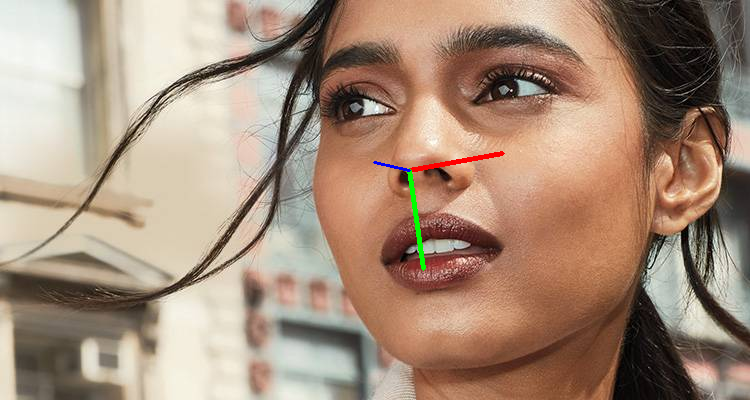

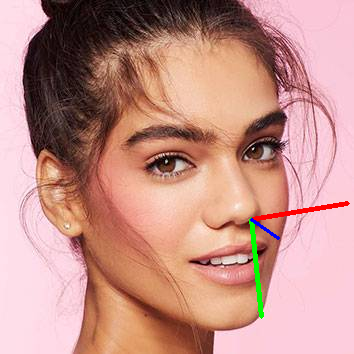

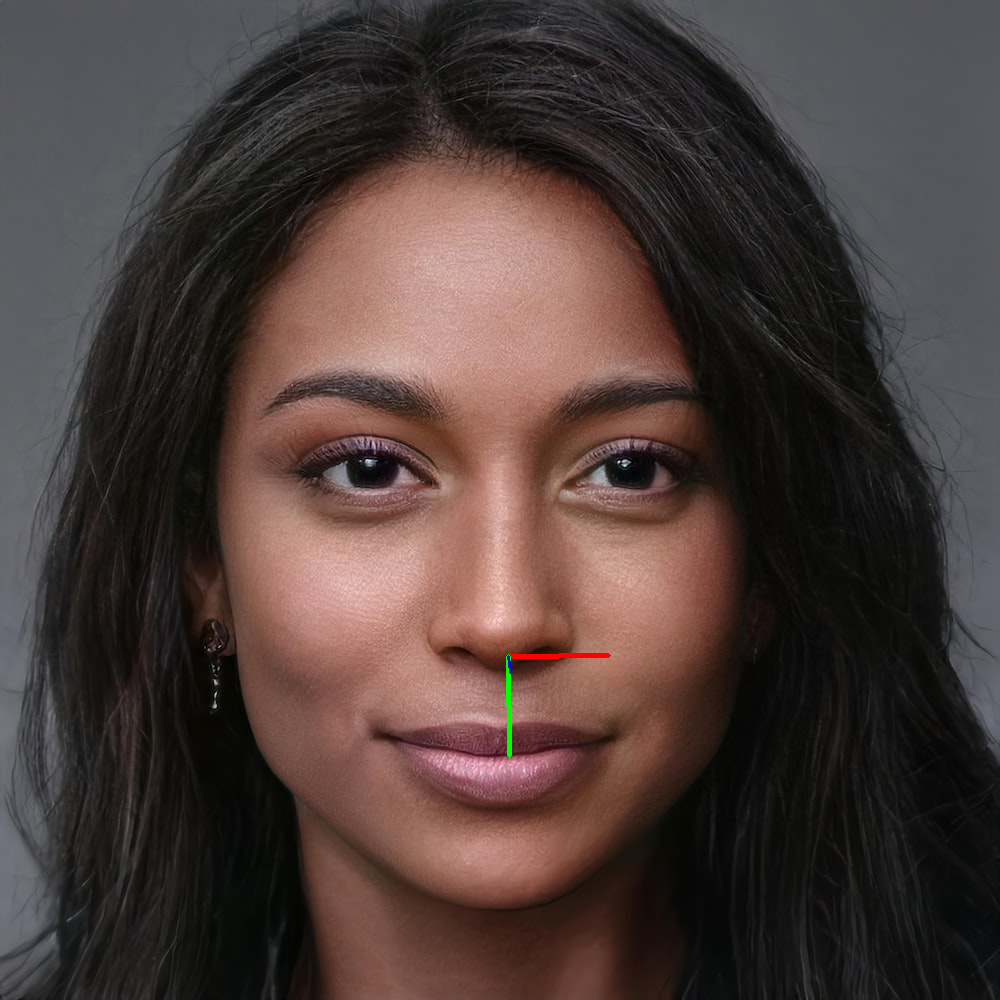

In [170]:
for img in draw_images(frames):
    cv2_imshow(img)

## Testing the model on a video

In [171]:
cap = cv2.VideoCapture('/content/Billie.mp4')
frame_rate = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('/content/output.mp4', # output video path
						fourcc, frame_rate, (width, height))
frames =[]
while True:
        try:
        # Read the next frame from the video
            ret, frame = cap.read()
            if not ret:
              break
            frame = cv2.flip(frame,1)
            frames.append(frame)
        except Exception as error:
         print(error)
        
for frame in draw_images(frames):
    out.write(frame)         
  
cap.release()
out.release()